In [10]:
import numpy as np
#from jax import grad, jacrev, jacfwd, jit, vmap
#import jax.numpy as jnp
#import jax.scipy as jscp

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.svm import SVC

import seaborn as sns
import scipy as scp

#import jax
#jax.config.update("jax_platform_name", "cpu")

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})


np.random.seed(32)

In [3]:
Phi_g = lambda v: scp.stats.norm.cdf(v, loc=0, scale=1)
phi_g = lambda v: scp.stats.norm.pdf(v, loc=0, scale=1)

In [4]:
def psi_g(alpha, sigma):
    return Phi_g((1- alpha)/sigma) * (1 - alpha) + phi_g((1- alpha)/sigma) * sigma

In [5]:
Phi_m = lambda v: (1 + v/np.sqrt(1 + v**2))/2
phi_m = lambda v: 1/(2 * np.sqrt(1 + v**2))

The two terms which make up the smooth hinge loss are,
\begin{align*}
    \Phi_m(v) = (1 + v/\sqrt{(1 + v^2)})/2 \\
    \phi_m(v) = 1/(2 \cdot \sqrt{(1 + v^2)}).
\end{align*}

Where the final form is,
\begin{align*}
    \psi_m(v) = \Phi_m(v/\sigma) \cdot v + \phi_m(v/\sigma) \cdot \sigma,
\end{align*}
for $v = 1 - \alpha$ and we use $\alpha = yXw$ for the SVM.

Now, the derivative for the individual terms wrt $v$ is,

\begin{align*}
    \frac{\partial \Phi_m(v)}{\partial v} = \frac{1}{2(v^2+1)^{\frac{3}{2}}} \\
    \frac{\partial \phi_m(v)}{\partial v} = -\frac{v}{2 (v^2 + 1)^{\frac{3}{2}}}
\end{align*}

$(1 + (v/\sigma)/(\sqrt{1+(v/\sigma)^2}))*v/2 + 1/(2\sqrt{(1+(v/\sigma)^2})) * \sigma$
$(1 + (1-\alpha/\sigma)/(\sqrt{1+(1-\alpha/\sigma)^2}))*1-\alpha/2 + 1/(2\sqrt{(1+(1-\alpha/\sigma)^2})) * \sigma$
$(1 + (1-yXw/\sigma)/(\sqrt{1+(1-yXw/\sigma)^2}))*1-yXw/2 + 1/(2\sqrt{(1+(1-yXw/\sigma)^2})) * \sigma$

So, the derivative of the smooth hinge loss for $v = 1 - \alpha$ is,
\begin{align*}
    \frac{\partial \psi_m(v)}{\partial v} &= \left(\frac{\partial \Phi_m(v)}{\partial v} \cdot v + \Phi_m(v) \cdot \frac{\partial v}{\partial \alpha} \right) + \frac{\partial \phi_m(v)}{\partial v} \cdot \sigma \\
    &= \frac{1}{2(v^2+1)^{\frac{3}{2}}} \cdot v - \frac{1}{2}\left(1 + \frac{v}{\sqrt{(1 + v^2)}}\right) -\frac{v}{2 (v^2 + 1)^{\frac{3}{2}}} \cdot \sigma \\
    &= \frac{v(1 - \sigma)}{2(v^2+1)^{\frac{3}{2}}} - \frac{1}{2} - \frac{v}{2(1 + v^2)^{\frac{1}{2}}} \\
    &= \frac{v(1 - \sigma - (1 + v^2))}{2(v^2+1)^{\frac{3}{2}}} - \frac{1}{2}.
\end{align*}

## Gradient descent on derivative by hand
$$
    = -\frac{1}{2} y_i x_i - \frac{1}{2} \left[(1 - y_i w^t x_i)^2 + \sigma^2\right]^{-1/2} (1 - y_i w^T x_i) (-y_i x_i)
$$

In [6]:
def nabla_psi(alpha, sigma):
    v = 1 - alpha
    return (v * (1 - sigma + (1 + v**2)))/(2 * np.sqrt((v**2 + 1))**3) - 1/2

In [7]:
def psi_m(alpha, sigma):
    return Phi_m((1 - alpha)/sigma) * (1 - alpha) + phi_m((1 - alpha)/sigma) * sigma

In [8]:
def hinge_loss(alpha):
    mx = lambda v: max(0, 1 - v)
    return list(map(mx, alpha))

In [14]:
fig, ax = plt.subplots()
xx = np.linspace(0, 2, 50)
sigmas = [2e-5, 2e-1, 5e-1, 1]
for s in sigmas:
    ax.plot(xx, psi_m(xx, s), label=f"$\sigma$={s}")

ax.plot(xx, hinge_loss(xx), label="True Hinge", linestyle='--', c='black')
ax.legend()

ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
ax.set_xlim(0, 2)
#ax.set_ylim(-1, 1)
plt.tight_layout()
plt.show()
plt.savefig('smoothhinge_sigma.pgf', bbox_inches='tight', pad_inches=0)

/tmp/ipykernel_4019/3359691795.py:16: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown
  plt.show()


In [7]:
def L(w, X, y, sigma, lbd=0.3):
    return 1/2 * lbd *  np.linalg.norm(w, ord=2)**2 + np.mean(psi_m(y * (X @ w), sigma))

In [8]:
def L_alt(w, X, y, sigma, lbd=0.3):
    return np.mean(psi_m(y * (X @ w), sigma))

In [9]:
#X, y = make_blobs(n_samples=200, n_features=2, centers=[[-1,-1], [1,1]], cluster_std=1.5)
X, y = make_blobs(n_samples=150, n_features=2, centers=[[-0.15,0], [0.15,0]], cluster_std=0.1)
#X, y = make_blobs(n_samples=250, n_features=2, centers=[[0,-1], [0,1]])
#X, y = make_moons(n_samples=100, noise=0.2, random_state=13)
y[np.where(y == 0)] = -1

In [10]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
y = data.target
y[np.where(y == 0)] = -1
print(X)
print(y)

[[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1
  1  1  1  1  1 -1 -1  1 -1 -1  1  1  1  1 -1  1 -1 -1  1  1  1  1 -1  1
 -1 -1  1 -1  1 -1 -1  1  1  1 -1 -1  1 -1 -1 -1  1  1  1 -1  1  1 -1 -1
  1  1  1 -1 -1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1 -1 -1 -1
  1 -1 -1  1  1  1 -1 -1  1 -1  1 -1 -1  1 -1 -1  1  1 -1  1  1 -1  1  1
  1  1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1 -1 -1  1 -1  1  1 -1
 -1  1  1 -1 -1  1  1  1  1 -1  1  1 -1 -1 -1  1 -1  1 -1  1  1  1 -1  1
  1 -1 -

In [11]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [12]:
clf = SVC(kernel='linear').fit(X, y)
print(clf.coef_)
print(clf.intercept_)

[[-0.32157975 -0.0963414  -0.29618472 -0.27044914  0.0145657   0.61925944
  -0.75749079 -0.90968508 -0.07847361  0.34800574 -0.84095245  0.30550603
  -0.23541953 -0.89135374 -0.35509455  0.39115374  0.37739417 -0.46041889
   0.10093298  0.88583541 -0.59013908 -0.97190388 -0.33349947 -0.71227359
  -0.42708268  0.1721726  -1.03818882 -0.09378355 -0.44679874 -0.85526809]]
[0.04438971]


In [13]:
#X = np.c_[X, np.ones(X.shape[0])]

In [14]:
print(X.shape)
print(y.shape)

n = X.shape[0]
p = X.shape[1]

(569, 30)
(569,)


In [15]:
def nabla_psi_X(X, y, w, sigma):
    #numerator = y @ X * (sigma * np.sqrt((1 - y @ X * w/sigma)**2 + 1)**3 + y @ X * w - sigma + 2)
    numerator = (sigma * np.sqrt((1 - y @ X * w/sigma)**2 + 1)**3 + y @ X * w - sigma + 2)
    denom = 2 * sigma * np.sqrt((1 - y @ X * w/sigma)**2 + 1)**3
    return -numerator/denom

In [16]:
def nabla_fgd(X, y, w, sigma, lbd):
    return (lbd * w - 1/n * y @ X * Phi_m((1 - y @ X * w)/sigma))
    #return (1/2 * y @ X - 1/2 * 1/np.sqrt((1 - y @ X * w)**2 + sigma**2) @ (1 - y @ X * w) * (y @ X))

def nabla_fgd_single(X, y, w, sigma, lbd):
    return (lbd * w - 1/n * y * X * Phi_m((1 - y * X * w)/sigma))
    #return (1/2 * y * X - 1/2 * 1/np.sqrt((1 - y * X * w)**2 + sigma**2) * (1 - y * X * w) * (y * X))

In [17]:
def hess_fgd(X, y, w, sigma, lbd):
    d = phi_m((1 - y @ X * w)/sigma)
    D = np.eye(p)
    for i in range(p):
        D[i, i] = d[i]
        
    hess = lbd * np.eye(p) + 1/n * (X @ D).T @ X
    return hess

In [18]:
def hess_fgd_single(X, y, w, sigma, lbd):
    d = phi_m((1 - y * X * w)/sigma)
    D = np.eye(p)
    for i in range(p):
        D[i, i] = d[i]
        
    hess = lbd * np.eye(p) + 1/n * (X @ D).T @ X
    return hess

In [19]:
# gradient testing
w_og = np.zeros(p)
n_iter = 2250
eta = 1e-2
sigma = 0.01
lbd = 0.95

alpha_t = 2.5 * eta * p/n
#alpha_t = 7e-3/n

w_true_og = np.zeros((n, p))
w_cv_og = np.zeros((n, p))

thresh = 1e-5

for t in range(n_iter):
    f_grad = nabla_fgd(X, y, w_og, sigma, lbd)
    f_hess = hess_fgd(X, y, w_og, sigma, lbd)
    
    if np.linalg.norm(f_grad) < thresh:
        print(f"stopping early at iteration {t}")
        break
    
    hess_per_sample = np.zeros((n, p, p))
    for i in range(n):
        hess_per_sample[i] = hess_fgd_single(X[i], y[i], w_og, sigma, lbd)
        
    grad_per_sample = np.zeros((n, p))
    for i in range(n):
        grad_per_sample[i] = nabla_fgd_single(X[i], y[i], w_og, sigma, lbd)
        
    hess_minus_i = f_hess - hess_per_sample
    grad_minus_i = f_grad - grad_per_sample
    
    #print(f_hess)
    w_cv_og = w_cv_og - alpha_t * grad_minus_i - alpha_t * np.vectorize(np.matmul, signature='(p, p),(p)->(p)')(hess_minus_i, (w_cv_og - w_og))
    #w_cv_og /= np.asarray([np.linalg.norm(w_cv_og, axis=1)] * p).T
    
    for i in range(n):
        X_temp = np.delete(X, (i), axis=0)
        y_temp = np.delete(y, (i), axis=0)
        w_true_og[i] = w_true_og[i] - eta * nabla_fgd(X_temp, y_temp, w_true_og[i], sigma, lbd)
        #w_true_og[i] = w_true_og[i] - eta * (lbd * w_true_og[i] - y @ X * Phi_m((1 - y_temp @ X_temp * w_true_og[i])/sigma))
        
    #w_true_og /= np.asarray([np.linalg.norm(w_true_og, axis=1)] * p).T
    w_og = w_og - eta * f_grad
    #w_og /= np.linalg.norm(w_og)
    print(f"{w_og} | IACV: {np.mean(np.linalg.norm(w_true_og - w_cv_og, 2, axis=1))} | baseline: {np.mean(np.linalg.norm(w_true_og - w_og, 2, axis=1))}")


#w_og /= np.linalg.norm(w_og)
print(np.mean(w_true_og, axis=0))
print(np.mean(w_cv_og, axis=0))
#w_og = w_og/np.linalg.norm(w_og)
#print(w_og/np.linalg.norm(w_og))

[-7.05909023e-03 -4.01467949e-03 -7.18099517e-03 -6.85559645e-03
 -3.46713465e-03 -5.76824739e-03 -6.73352606e-03 -7.50955214e-03
 -3.19579178e-03  1.24134598e-04 -5.48396227e-03  8.02899828e-05
 -5.37766312e-03 -5.30122716e-03  6.48018616e-04 -2.83318811e-03
 -2.45346762e-03 -3.94560979e-03  6.30628289e-05 -7.53962785e-04
 -7.50800441e-03 -4.41807161e-03 -7.57047355e-03 -7.09580113e-03
 -4.07540039e-03 -5.71472185e-03 -6.37817279e-03 -7.67347306e-03
 -4.02540320e-03 -3.13171741e-03] | IACV: 0.024480434225568955 | baseline: 8.675448114282208e-05
[-0.00699208 -0.00797687 -0.00711282 -0.00679053 -0.00690055 -0.00571363
 -0.00666962 -0.00743825 -0.00636085  0.00024709 -0.00543214  0.00015982
 -0.0053269  -0.00525123  0.00128988 -0.00563929 -0.00488355 -0.00784631
  0.00012553 -0.00150076 -0.00743672 -0.00438506 -0.00749859 -0.00702844
 -0.00807924 -0.00566063 -0.00631767 -0.00760061 -0.00799632 -0.00623336] | IACV: 0.028898776507714344 | baseline: 0.00013033916453917006
[-0.00692571 -0.00

[-0.00588945 -0.00672137 -0.00599102 -0.00571993 -0.00583747 -0.00481635
 -0.00561827 -0.00626485 -0.00570789  0.0022709  -0.00458221  0.00146881
 -0.0044954  -0.00443342  0.01185452 -0.00717064 -0.00736592 -0.00661208
  0.00115366 -0.01379238 -0.00626356 -0.00418491 -0.00631563 -0.00592004
 -0.00680714 -0.00477212 -0.00532252 -0.00640149 -0.00673766 -0.00581739] | IACV: 0.02936261291239869 | baseline: 0.0006147958558085396
[-0.00583359 -0.00665787 -0.00593419 -0.00566571 -0.00578577 -0.00477102
 -0.00556502 -0.0062054  -0.00570641  0.00237346 -0.00453942  0.00153515
 -0.00445365 -0.00439247  0.01238989 -0.00710542 -0.00736592 -0.00654968
  0.00120577 -0.01441522 -0.00620412 -0.00418481 -0.0062557  -0.00586389
 -0.00674278 -0.00472725 -0.00527214 -0.00634074 -0.006674   -0.00581734] | IACV: 0.02954051417971929 | baseline: 0.0006403940986448529
[-0.00577827 -0.00659499 -0.00587791 -0.005612   -0.00573512 -0.00472615
 -0.00551229 -0.00614652 -0.00570566  0.00247505 -0.00449708  0.0016008

[-0.0048684  -0.00556598 -0.00495206 -0.00472888 -0.00527574 -0.00399404
 -0.00464531 -0.00517777 -0.00570492  0.00414713 -0.00381687  0.00268236
 -0.00375878 -0.00372345  0.02164675 -0.00640813 -0.00736592 -0.00547927
  0.00210683 -0.02341386 -0.0051767  -0.00418464 -0.00521965 -0.00489359
 -0.0056347  -0.00395939 -0.00440278 -0.00529046 -0.005579   -0.00581729] | IACV: 0.034021559498584215 | baseline: 0.0010696883123445145
[-0.00482234 -0.00551446 -0.00490519 -0.0046842  -0.0052754  -0.00395759
 -0.00460145 -0.00512871 -0.00570492  0.00423187 -0.00378436  0.00273717
 -0.00372902 -0.00369677  0.02208874 -0.00640789 -0.00736592 -0.00542908
  0.00214988 -0.02341397 -0.00512765 -0.00418464 -0.00517018 -0.00484728
 -0.00558225 -0.0039235  -0.0043614  -0.00524032 -0.0055273  -0.00581729] | IACV: 0.034092434590248175 | baseline: 0.0010889846329357696
[-0.00477673 -0.00546356 -0.00485877 -0.00463995 -0.00527522 -0.0039216
 -0.00455803 -0.00508012 -0.00570492  0.0043158  -0.00375259  0.002791

[-0.00402781 -0.00469819 -0.00409622 -0.00391413 -0.00527502 -0.0033818
 -0.00384638 -0.00428135 -0.00570492  0.00569729 -0.00341955  0.003685
 -0.00347639 -0.00352232  0.02717627 -0.00640771 -0.00736592 -0.00469919
  0.00289434 -0.02341395 -0.00428047 -0.00418464 -0.00431576 -0.00404839
 -0.0047219  -0.00337335 -0.00365272 -0.00437398 -0.00470146 -0.00581729] | IACV: 0.03449580260995276 | baseline: 0.0013717665461304694
[-0.00399001 -0.004672   -0.0040577  -0.00387756 -0.00527502 -0.00336152
 -0.00381059 -0.00424095 -0.00570492  0.0057673  -0.00341705  0.00373028
 -0.00347584 -0.00352215  0.02717627 -0.00640771 -0.00736592 -0.00468635
  0.00292991 -0.02341395 -0.00424008 -0.00418464 -0.00427501 -0.00401037
 -0.00468824 -0.00335639 -0.00361952 -0.00433266 -0.00467361 -0.00581729] | IACV: 0.03440584520205344 | baseline: 0.0013901252897548435
[-0.00395259 -0.00464943 -0.00401957 -0.00384138 -0.00527502 -0.003343
 -0.00377518 -0.00420094 -0.00570492  0.00583665 -0.00341528  0.00377513
 -0

[-0.00334318 -0.00458422 -0.00339699 -0.00325616 -0.00527502 -0.00325348
 -0.00320676 -0.00354538 -0.00570492  0.00697805 -0.00341126  0.00451339
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00354499 -0.02341395 -0.00354467 -0.00418464 -0.00357323 -0.00335929
 -0.00451907 -0.00328188 -0.00309473 -0.0036205  -0.00457257 -0.00581729] | IACV: 0.03282768550792653 | baseline: 0.001642887181633198
[-0.00331292 -0.00458422 -0.00336591 -0.00322758 -0.00527502 -0.00325338
 -0.00317951 -0.0035124  -0.00570492  0.00703589 -0.00341126  0.0045508
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00357437 -0.02341395 -0.0035117  -0.00418464 -0.00353994 -0.00332877
 -0.00451905 -0.00328183 -0.00307579 -0.00358667 -0.00457257 -0.00581729] | IACV: 0.03275086011582485 | baseline: 0.001653669643714657
[-0.00328306 -0.00458422 -0.00333521 -0.00319947 -0.00527502 -0.00325332
 -0.00315284 -0.00347978 -0.00570492  0.00709318 -0.00341126  0.00458786
 

[-0.00283375 -0.00458421 -0.00285858 -0.0028209  -0.00527502 -0.00325317
 -0.00283757 -0.00295495 -0.00570492  0.00803621 -0.00341125  0.00519781
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00408256 -0.02341395 -0.00295444 -0.00418464 -0.0029753  -0.00284023
 -0.00451902 -0.00328173 -0.0029621  -0.00301069 -0.00457256 -0.00581729] | IACV: 0.031400094613128336 | baseline: 0.0018418933493895221
[-0.00281603 -0.00458421 -0.00283776 -0.00281097 -0.00527502 -0.00325317
 -0.00283253 -0.00292959 -0.00570492  0.008084   -0.00341125  0.00522872
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00410684 -0.02341395 -0.0029291  -0.00418464 -0.00294942 -0.00282145
 -0.00451902 -0.00328173 -0.00296192 -0.00298403 -0.00457256 -0.00581729] | IACV: 0.03133442376299953 | baseline: 0.001850977993798469
[-0.0027995  -0.00458421 -0.00281783 -0.00280251 -0.00527502 -0.00325317
 -0.00282854 -0.00290472 -0.00570492  0.00813134 -0.00341125  0.0052593

[-0.00269613 -0.00458421 -0.00265564 -0.00276935 -0.00527502 -0.00325317
 -0.00281581 -0.00257738 -0.00570492  0.00894996 -0.00341125  0.00578883
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00454677 -0.02341395 -0.00257757 -0.00418464 -0.00257154 -0.0026836
 -0.00451902 -0.00328173 -0.00296144 -0.00256919 -0.00457256 -0.00581729] | IACV: 0.030113237850452352 | baseline: 0.0020168409977008614
[-0.00269588 -0.00458421 -0.00265494 -0.00276931 -0.00527502 -0.00325317
 -0.0028158  -0.00257104 -0.00570492  0.00898907 -0.00341125  0.00581412
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00456664 -0.02341395 -0.00257128 -0.00418464 -0.00256331 -0.00268326
 -0.00451902 -0.00328173 -0.00296144 -0.00255765 -0.00457256 -0.00581729] | IACV: 0.03005567901364767 | baseline: 0.0020243834257908334
[-0.0026957  -0.00458421 -0.00265441 -0.00276929 -0.00527502 -0.00325317
 -0.0028158  -0.00256578 -0.00570492  0.00902781 -0.00341125  0.0058391

[-0.00269516 -0.00458421 -0.00265281 -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254562 -0.00570492  0.00966543 -0.00341125  0.00625159
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00491024 -0.02341395 -0.00254611 -0.00418464 -0.00252685 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249595 -0.00457256 -0.00581729] | IACV: 0.02898138183502632 | baseline: 0.0021553802550818416
[-0.00269516 -0.00458421 -0.00265281 -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254558 -0.00570492  0.00969774 -0.00341125  0.00627249
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00492665 -0.02341395 -0.00254607 -0.00418464 -0.00252678 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.0024958  -0.00457256 -0.00581729] | IACV: 0.02892502223885337 | baseline: 0.0021616630190013125
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254555 -0.00570492  0.00972975 -0.00341125  0.0062931

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01025655 -0.00341125  0.00663392
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00521054 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249534 -0.00457256 -0.00581729] | IACV: 0.027851205826828793 | baseline: 0.0022706508592357363
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01028325 -0.00341125  0.00665119
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.0052241  -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249534 -0.00457256 -0.00581729] | IACV: 0.027794521489083252 | baseline: 0.002275872847661641
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01030969 -0.00341125  0.006668

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01074494 -0.00341125  0.00694982
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00545865 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.02671446967833156 | baseline: 0.002366382371234469
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01076699 -0.00341125  0.00696408
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00546986 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.02665747534387191 | baseline: 0.0023707155899004976
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01078884 -0.00341125  0.00697821

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01114845 -0.00341125  0.00721081
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00566365 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.02557228552638999 | baseline: 0.0024457773089428436
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01116667 -0.00341125  0.00722259
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.0056729  -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.025515068128993068 | baseline: 0.002449369029197575
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01118472 -0.00341125  0.0072342

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01148183 -0.00341125  0.00742644
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00583301 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.02442673901201153 | baseline: 0.002511561307479951
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01149689 -0.00341125  0.00743618
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00584066 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.02436941813716985 | baseline: 0.0025145361033275604
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.0115118  -0.00341125  0.00744582

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01175727 -0.00341125  0.0076046
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00597295 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.023280389432658668 | baseline: 0.002566031267108935
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01176971 -0.00341125  0.00761264
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00597927 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.02322310002651705 | baseline: 0.00256849372572501
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01178204 -0.00341125  0.00762061
 

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01198485 -0.00341125  0.00775179
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00608856 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.022135999378843158 | baseline: 0.0026111110833106853
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01199513 -0.00341125  0.00775844
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00609378 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.022078881848820613 | baseline: 0.0026131486010436047
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01200531 -0.00341125  0.00776

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01217287 -0.00341125  0.00787341
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00618408 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.02099638660738689 | baseline: 0.002648405987894857
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01218136 -0.00341125  0.0078789
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00618839 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.020939581829170127 | baseline: 0.002650091371587195
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01218977 -0.00341125  0.00788434


[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01232822 -0.00341125  0.00797388
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.006263   -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.01986435783235137 | baseline: 0.0026792518689960324
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01233523 -0.00341125  0.00797842
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00626656 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.019808005481751843 | baseline: 0.002680645644296876
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01234218 -0.00341125  0.0079829

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01245657 -0.00341125  0.0080569
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.0063282  -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.01874269887527587 | baseline: 0.0027047584744519224
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01246236 -0.00341125  0.00806065
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00633115 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.018686938105914982 | baseline: 0.002705910883062897
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.0124681  -0.00341125  0.00806436

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01256261 -0.00341125  0.00812549
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00638208 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.017634205916082623 | baseline: 0.0027258465159796133
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.0125674  -0.00341125  0.00812859
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00638451 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.01757917783479614 | baseline: 0.002726799218399132
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01257214 -0.00341125  0.0081316

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01265022 -0.00341125  0.00818216
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00642658 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.016541750067101808 | baseline: 0.0027432791570791448
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01265418 -0.00341125  0.00818472
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.0064286  -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.016487601779047442 | baseline: 0.002744066670927668
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.0126581  -0.00341125  0.008187

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01272261 -0.00341125  0.00822898
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00646336 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.015468373200704415 | baseline: 0.0027576885317569934
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01272588 -0.00341125  0.00823109
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00646502 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.015415263450233956 | baseline: 0.002758339439409153
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01272911 -0.00341125  0.008233

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01278241 -0.00341125  0.00826766
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00649374 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.014417417716962078 | baseline: 0.002769597964874507
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01278511 -0.00341125  0.00826941
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00649511 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.01436552437655862 | baseline: 0.002770135923223036
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01278779 -0.00341125  0.00827114

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01283182 -0.00341125  0.00829962
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00651885 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.01339269747474193 | baseline: 0.0027794405254497317
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01283406 -0.00341125  0.00830106
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00651998 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.013342227367257677 | baseline: 0.0027798851077755035
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01283627 -0.00341125  0.008302

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01287265 -0.00341125  0.00832603
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00653959 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.01239872201181641 | baseline: 0.0027875744793746824
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01287449 -0.00341125  0.00832722
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00654052 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.012349923810482635 | baseline: 0.002787941875771348
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01287632 -0.00341125  0.0083284

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01290638 -0.00341125  0.00834784
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00655672 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.011440991449958658 | baseline: 0.002794296136275032
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.0129079  -0.00341125  0.00834883
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00655749 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.011394172656101592 | baseline: 0.002794599735494882
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01290941 -0.00341125  0.0083498

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01293425 -0.00341125  0.00836587
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00657088 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.010526383529846712 | baseline: 0.002799850515493898
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01293551 -0.00341125  0.00836668
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00657152 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.010481932629163696 | baseline: 0.002800101387730649
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01293675 -0.00341125  0.0083674

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01295727 -0.00341125  0.00838076
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00658258 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.009663651927369257 | baseline: 0.002804440192364676
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01295831 -0.00341125  0.00838143
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.0065831  -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.009622066369607456 | baseline: 0.002804647489486078
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01295934 -0.00341125  0.0083821

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01297715 -0.00341125  0.00839362
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00659268 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.008825953050465863 | baseline: 0.0028084039165959707
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.012978   -0.00341125  0.00839417
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00659311 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.008788066789706278 | baseline: 0.00280857357722249
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01297885 -0.00341125  0.0083947

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01299549 -0.00341125  0.00840548
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00660199 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.0079755085203557 | baseline: 0.0028120605853961846
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01299617 -0.00341125  0.00840592
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00660234 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.007942970922415412 | baseline: 0.0028121955216086156
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01299684 -0.00341125  0.0084063

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01300843 -0.00341125  0.00841385
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00660857 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.007349039811620169 | baseline: 0.0028146406532272607
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01300899 -0.00341125  0.00841421
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00660885 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.0073224012561898056 | baseline: 0.0028147510866332907
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01300954 -0.00341125  0.0084

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01301856 -0.00341125  0.00842041
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00661371 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.006879067485970463 | baseline: 0.0028166609536665658
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01301902 -0.00341125  0.0084207
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00661395 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.0068592485305843396 | baseline: 0.002816752199208601
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01301948 -0.00341125  0.008421

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01302694 -0.00341125  0.00842582
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00661797 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.0065565206400343985 | baseline: 0.002818330218570099
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01302731 -0.00341125  0.00842606
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00661816 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.0065446537311934705 | baseline: 0.0028184056094615988
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01302769 -0.00341125  0.0084

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01303385 -0.00341125  0.00843029
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00662148 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.0064014830091275446 | baseline: 0.0028197094302759257
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01303416 -0.00341125  0.0084305
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00662164 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.006398372739548217 | baseline: 0.002819771720922313
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01303447 -0.00341125  0.008430

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01303982 -0.00341125  0.00843416
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00662451 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.006430214932626658 | baseline: 0.0028209004473157707
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01304008 -0.00341125  0.00843432
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00662464 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.006436462394819345 | baseline: 0.0028209514248832227
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01304033 -0.00341125  0.00843

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01304513 -0.00341125  0.00843759
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00662721 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.0066800536186289675 | baseline: 0.0028219581936169817
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01304533 -0.00341125  0.00843772
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00662731 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.006695713922973325 | baseline: 0.0028219991237105387
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01304554 -0.00341125  0.0084

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01304888 -0.00341125  0.00844002
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00662912 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.0070606150926456526 | baseline: 0.002822706968793502
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01304905 -0.00341125  0.00844012
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.0066292  -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.007083117644011816 | baseline: 0.0028227407861483697
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01304922 -0.00341125  0.00844

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01305212 -0.00341125  0.00844211
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00663076 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.00759234858822149 | baseline: 0.002823353563096806
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01305226 -0.00341125  0.0084422
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00663083 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.007620500149449784 | baseline: 0.0028233812382363827
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.0130524  -0.00341125  0.00844229

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01305511 -0.00341125  0.00844405
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00663228 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.008325678353842068 | baseline: 0.0028239500182846485
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01305522 -0.00341125  0.00844412
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00663234 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.008358559034184764 | baseline: 0.0028239720274072454
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01305533 -0.00341125  0.00844

[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01305722 -0.00341125  0.00844541
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.00663335 -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.009047304493040371 | baseline: 0.0028243708357650046
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.01305731 -0.00341125  0.00844547
 -0.00347465 -0.0035218   0.02717627 -0.00640771 -0.00736592 -0.00466081
  0.0066334  -0.02341395 -0.00254595 -0.00418464 -0.00252658 -0.00268225
 -0.00451902 -0.00328173 -0.00296144 -0.00249533 -0.00457256 -0.00581729] | IACV: 0.009083132417629567 | baseline: 0.002824388847286506
[-0.00269516 -0.00458421 -0.0026528  -0.00276921 -0.00527502 -0.00325317
 -0.00281577 -0.00254546 -0.00570492  0.0130574  -0.00341125  0.008445

In [20]:
print(np.mean(np.linalg.norm(w_true_og - w_cv_og, 2, axis=1)))
print(np.mean(np.linalg.norm(w_true_og - w_og, 2, axis=1)))

0.009671232769487888
0.0028246548309582057


In [21]:
# compute FG accuracy

fg_correct = 0
for i, x_i in enumerate(X):
    fg_correct += (np.sign(x_i @ w_og) == y[i])
    
print(fg_correct/X.shape[0])

0.8734622144112478


In [22]:
# compute base SVM accuracy
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X)
print(accuracy_score(y, y_pred))

0.9876977152899824


TypeError: Axes.scatter() got multiple values for argument 'c'

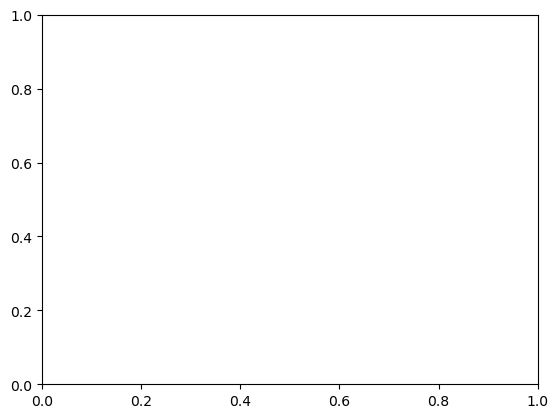

In [23]:
def plot_line(ax, theta, label, color, **kwargs):
    #theta[:2] /= np.linalg.norm(theta[:2], 2) ## probably get rid of this
    a = -theta[0] / theta[1]
    #yy = a * xx - theta[2] / theta[1]
    yy = a * xx
    ax.plot(xx, yy, label=label, c=color, **kwargs)

fig, ax = plt.subplots()
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
ax.scatter(*X.T, c=y, cmap=plt.cm.bwr, linewidths=3)

#mins = np.argsort(np.sum(w_cv, axis=1), axis=0)[:50]
#print(np.sum(w_cv, axis=1)[mins])
#ax.scatter(*X[mins].T, c="black", linewidths=10)

#plot_line(ax, [*clf.coef_[0], clf.intercept_[0]], "sklearn", "plum")
#plot_line(ax, w, f"SmoothHinge ($\sigma$={sigma})", "purple")
plot_line(ax, w_og, f"FGD", "green")

ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))
ax.legend()

#ws = 1.45 # 1.75
#hs = 1.35 # 1.25
#fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.tight_layout()
plt.show()
#plt.savefig('smoothhinge_comp.pgf', bbox_inches='tight', pad_inches=0)

In [ ]:
fig, ax = plt.subplots()
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
ax.scatter(*X.T, c=y, cmap=plt.cm.bwr, linewidths=3)

#median_w = np.median(np.abs(w_cv_og), axis=0)
median_w = np.median(w_cv_og, axis=0)
#median_w /= np.linalg.norm(median_w, 2)
plot_line(ax, median_w, "IACV median", "black", linestyle='--')

#mean_w = np.mean(np.abs(w_cv_og), axis=0)
mean_w = np.mean(w_cv_og, axis=0)
#mean_w /= np.linalg.norm(mean_w, 2)
plot_line(ax, mean_w, "IACV mean", "purple")

#w_true_mean = np.mean(np.abs(w_true_og), axis=0)
w_true_mean = np.mean(w_true_og, axis=0)
w_true_mean /= np.linalg.norm(w_true_mean, 2)

plot_line(ax, w_true_mean, f"True CV Mean", "blue")
plot_line(ax, w_og, f"SmoothHinge", "green")

plot_line(ax, [*clf.coef_[0], clf.intercept_[0]], "sklearn", "red", alpha=0.8)

ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))
fig.legend()

#ws = 1.45 # 1.75
#hs = 1.35 # 1.25
#fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.tight_layout()
plt.show()
#plt.savefig('smoothhinge_stats.pgf', bbox_inches='tight', pad_inches=0)

In [ ]:
fig, ax = plt.subplots()
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
ax.scatter(*X.T, c=y, cmap=plt.cm.bwr, linewidths=3)

t_percentile = 85
l_percentile = 100 - t_percentile
top_w = np.asarray([np.percentile(w_cv_og[:, i], t_percentile) for i in range(w_cv_og.shape[1])])
#top_w = np.abs(top_w)
#top_w /= np.linalg.norm(top_w, 2)
print(top_w)
plot_line(ax, top_w, f"{t_percentile}th Percentile", "black", linestyle='--')

bottom_w = np.asarray([np.percentile(w_cv_og[:, i], l_percentile) for i in range(w_cv_og.shape[1])])
#bottom_w = np.abs(bottom_w)
#bottom_w /= np.linalg.norm(bottom_w, 2)
print(bottom_w)
plot_line(ax, bottom_w, f"{l_percentile}th Percentile", "black")

#mid_p = (np.abs(bottom_w) + np.abs(top_w))/2
#mid_p = (bottom_w + top_w)/2
#print(mid_p)
#mid_p /= np.linalg.norm(mid_p, 2)
#plot_line(ax, median_w, "Median", "plum")
plot_line(ax, mean_w, "Mean", "plum")

ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
plt.scatter(X[:, 0], X[:, 1], c=np.sum(w_cv_og, axis=1))
plt.colorbar()
plt.plot()
plt.tight_layout()
#plt.savefig('smoothhinge_colorbar.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [ ]:
fig, ax = plt.subplots()
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
plt.scatter(X[:, 0], X[:, 1], c=np.sum(w_true_og, axis=1))
plt.colorbar()
plt.plot()
plt.tight_layout()
#plt.savefig('smoothhinge_colorbar.png', dpi=400, bbox_inches='tight', pad_inches=0)